# GuardRails for LLMs

In [ ]:
#pip install langchain_nvidia_ai_endpoints


In [10]:

from langchain_nvidia_ai_endpoints._common import NVEModel
import os

#Adding LangSmith utility 

#os.environ['LANGCHAIN_TRACING_V2'] = 'true'
#os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
#os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
#os.environ['LANGCHAIN_PROJECT'] = 'Name'

### We will be using Nvidia endpoint for LLM model calls and embeddings




In [11]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, ChatNVIDIA
os.environ["NVIDIA_API_KEY"] = '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'



embedder = NVIDIAEmbeddings(model="nvolveqa_40k", model_type=None)
os.environ["NVIDIA_API_KEY"] = os.getenv("NVIDIA_API_KEY")


## Embeddings for Semantic Guardrails

Embeddings serve as a foundational element for semantic guardrails in production models. This technique filters irrelevant or potentially harmful messages, ensuring the chatbot responds only to appropriate queries.

### Embedding vs. Autoregression-Guided Filtering

While it's tempting to use Large Language Models (LLMs) for filtering, embeddings offer a streamlined alternative. This method balances complexity, resource efficiency, and latency effectively.

**Pros and Cons of Autoregressive Routing:**

- **Pros:** It's straightforward, allowing for precise control over dialog progression. A carefully designed prompt can effectively screen questions.
- **Cons:** This approach can be resource-intensive and slow. For efficient semantic guardrails, consider these strategies:
  - A small, instruction-tuned model might serve as a zero-shot classifier, though its performance must remain stable. Standardizing inputs for optimal model performance is crucial.
  - Fine-tuning a smaller LLM for this specific task might emulate a larger model's effectiveness without significant overhead. This requires synthetic data curation and a one-time investment in fine-tuning.

Using an embedding model as a language backbone allows the development of a classifier to predict the suitability of inputs. I explore this approach, addressing any emerging challenges to enhance the chatbot's functionality.

###  Synthetic Data Generation

Starting with an NVIDIA Chatbot focused on technology and company details, we recognize its limitations but appreciate the simplicity for this exercise. My aim is to distinguish between *good* and *poor* inputs. Without access to real data, i'll create synthetic examples to guide our guardrail design.

###  Accelerating Embedding Generation

Once we have our synthetic data, embedding them efficiently is the next step. Moving beyond the slower `embed_query` and `embed_documents` methods, i'll employ **asynchronous techniques** for simultaneous embeddings. This approach optimizes our process but requires careful consideration for broader application.


In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
from operator import itemgetter
from pprint import pprint

## Useful method for mistral, which is currently tuned to output numbered outputs
def EnumParser(*idxs):
    '''Method that pulls out values from a mistral model that outputs numbered entries'''
    idxs = idxs or [slice(0, None, 1)]
    entry_parser = lambda v: v if (' ' not in v) else v[v.index(' '):]
    out_lambda = lambda x: [entry_parser(v).strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: itemgetter(*idxs)(out_lambda(x)))

instruct_llm = ChatNVIDIA(model="mixtral_8x7b") | EnumParser()

gen_prompt = {'input' : lambda x:x} | ChatPromptTemplate.from_messages([('user',
    "Please generate 20 representative conversations that would be {input}."
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure all of your outputs are numbered."
    " Example Response: \n1. <question>\n2. <question>\n3. <question>\n..."
)])

## Some that directly reference NVIDIA
responses_1 = (gen_prompt | instruct_llm).invoke(
    " reasonable for an Czech Bank document chatbot to be able to answer."
    " Vary the context to technology, research, finance, loans, investments, etc."
)


#print(*responses_1)


print("Reasonable Czech Bank Responses:", *responses_1, "", sep="\n")

## And some that  are not reasonable 
responses_2 = (gen_prompt | instruct_llm).invoke(
    " be reasonable for a fin tech document chatbot to be able to answer. Make sure to vary"
    " the context to technology, research, finance, investement, etc."
)
print("Reasonable non-Czech-Bank Responses:", *responses_2, "", sep="\n")

responses_3 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an Czech Bank document chatbot to answer,"
    " as it is irrelevant and will not be useful to answer (though not inherently harmful)."
)
print("Irrelevant Responses:", *responses_3, "", sep="\n")

responses_4 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for a Czech Bank document chatbot to answer,"
    " as it will reflect negatively on Czech Bank."
)
print("Harmful non-Czech-Bank", *responses_4, "", sep="\n")


good_responses = responses_1 + responses_2
poor_responses = responses_3 + responses_4

Reasonable Czech Bank Responses:
"Hello, can you explain how to set up online banking for your bank?"
"What types of loans does your bank offer? Can you provide more information about the interest rates and terms for each one?"
"I'm interested in investing in stocks. Can your bank provide any resources or tools to help me get started?"
"Can you help me understand the different types of bank accounts your bank offers, such as checking and savings accounts?"
"I'm having trouble accessing my online account. Can you help me reset my password?"
"Can you provide more information about your bank's mobile banking app, such as what features it offers and how to download it?"
"I'm considering applying for a credit card with your bank. Can you provide more information about the different credit card options and their benefits?"
"Can you help me understand the process for transferring money between accounts at your bank and accounts at other banks?"
"I'm interested in learning more about your bank

<br>

### **Generate More Embeddings (and faster)**

Next we embed them all into semantic vectors. Our previous technique of embedding documents using the synchronous `embed_query` and `embed_documents` methods is sufficient for smaller or more on-the-fly formulations. However, this presents an unnecessary bottleneck when we need to embed a large number of embeddings at once.

We will use asynchronous techniques to allow multiple embedding operations to happen simultaneously.

<br>

#### **Timing Solutions**

The `%%time` utility does not work for asynchronous solutions in the notebook, so the following is a scope-based timing utility which should make our lives easier. Below, we define it and test out how long it takes to embed the first 10 documents:

In [13]:
import time
import numpy as np

class Timer():
    '''Useful timing utilities '''
    def __enter__(self):
      self.start = time.perf_counter()

    def __exit__(self, *args, **kwargs):
        elapsed = time.perf_counter() - self.start
        print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")

with Timer():
    good_embeds = [embedder.embed_query(x) for x in good_responses[:10]]
    poor_embeds = [embedder.embed_query(x) for x in poor_responses[:10]]

print("Shape:", np.array(good_embeds).shape)
print("Shape:", np.array(poor_embeds).shape)


Executed in 31.17 seconds.
Shape: (10, 1024)
Shape: (10, 1024)



#### **Towards Asynchronous Embeddings**


In [14]:
with Timer():
    good_embed_gens = [embedder.aembed_query(query) for query in good_responses[10:20]]
print(good_embed_gens[0])

## NOTE: When you define coroutines, you will want to either execute them or close them.
##  Destroying an open coroutine object by overriding will throw a warning.
for gen in good_embed_gens:
    gen.close()

Executed in 0.00 seconds.
<coroutine object Embeddings.aembed_query at 0x000001687AE16180>


In [15]:
import asyncio

with Timer():
    tasks = [embedder.aembed_query(query) for query in good_responses[10:20]]
    good_embeds2 = await asyncio.gather(*tasks)

print("Shape:", np.array(good_embeds2).shape)

Executed in 2.43 seconds.
Shape: (10, 1024)




#### **Limiting Concurrency**

The concurrency can't be stacked infinitely. With enough tasks running concurrently, things can break, services can throttle, and resources can be exhausted. Use some controlling structures to limit the maximum concurrency, for example using the asyncio **semaphore** structure (an async primitive to limit max concurrency):


In [16]:
from collections import abc
import asyncio
from asyncio import Semaphore

In [17]:
import asyncio
from collections import abc
from typing import Callable
from functools import partial

async def embed_with_semaphore(
    text : str,
    embed_fn : Callable,
    semaphore : asyncio.Semaphore
) -> abc.Coroutine:
    async with semaphore:
        return await embed_fn(text)

## Making new embed method to limiting maximum concurrency
embed = partial(
    embed_with_semaphore,
    embed_fn = embedder.aembed_query,
    semaphore = asyncio.Semaphore(value=10)  
)

tasks = [embed(query) for query in good_responses[20:30]]

with Timer():
    good_embeds_3 = await asyncio.gather(*tasks)

Executed in 2.52 seconds.


<br>

#### **Embed The Rest of the Responses**



In [18]:
with Timer():
    good_tasks = [embed(query) for query in good_responses]
    poor_tasks = [embed(query) for query in poor_responses]

    print(good_tasks)
    print("_________")
    print(poor_tasks)
    all_tasks = good_tasks + poor_tasks
    embeds = await asyncio.gather(*all_tasks)
    #pprint(embeds)

    good_embeds = embeds[:len(good_tasks)]
    poor_embeds = embeds[len(good_tasks):]

print("Good Embeds Shape:", np.array(good_embeds).shape)
print("Poor Embeds Shape:", np.array(poor_embeds).shape)

#embeddings = np.vstack([good_embeds, poor_embeds])

#print(f"embeddings  Shape {embeddings.shape}")

#print(np.array(poor_embeds).shape)


[<coroutine object embed_with_semaphore at 0x000001687AEC3880>, <coroutine object embed_with_semaphore at 0x000001687AE12890>, <coroutine object embed_with_semaphore at 0x000001687AE11210>, <coroutine object embed_with_semaphore at 0x000001687AE132E0>, <coroutine object embed_with_semaphore at 0x000001687AFC8E50>, <coroutine object embed_with_semaphore at 0x000001687AFCB100>, <coroutine object embed_with_semaphore at 0x000001687AFCB010>, <coroutine object embed_with_semaphore at 0x000001687AFC86D0>, <coroutine object embed_with_semaphore at 0x000001687AFCAC50>, <coroutine object embed_with_semaphore at 0x000001687AFC9120>, <coroutine object embed_with_semaphore at 0x000001687AFCA4D0>, <coroutine object embed_with_semaphore at 0x000001687AFCA200>, <coroutine object embed_with_semaphore at 0x000001687AFC8F40>, <coroutine object embed_with_semaphore at 0x000001687AFC9F30>, <coroutine object embed_with_semaphore at 0x000001687AFC89A0>, <coroutine object embed_with_semaphore at 0x000001687A

### Confirming Semantic Density

Our reason for generating these embeddings hinges on the assumption that they would be useful for semantic filtering. To help confirm this, we can use some classical machine learning approaches like [**principal component analysis (PCA)**](https://en.wikipedia.org/wiki/Principal_component_analysis) or [**t-distributed stochastic neighbor embedding (t-SNE)**](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for dimensionality reduction. These techniques essentially transform high-dimensional data into lower-dimensional representations while trying to keep the important statistical properties intact.

In [19]:
pip install matplotlib 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


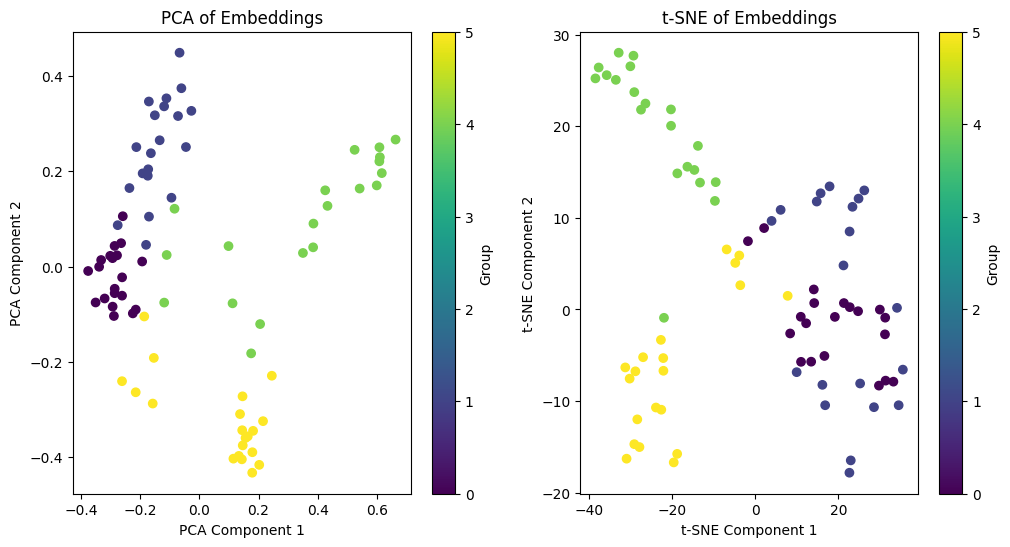

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Combine all groups into a single dataset
embeddings = np.vstack([good_embeds, poor_embeds])



# Labels for each point
labels = np.array([0]*20 + [1]*20 + [4]*20 + [5]*20)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE
perplexity_value = min(20 - 1, 5)  
tsne = TSNE(n_components=2, random_state=0, perplexity = perplexity_value)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()



###  Training the Classifier

From these embeddings, we can train up a simple classifier that predicts whether an embedding is good or bad.

A simple two-layer network is likely to be sufficient for this use case since we're leveraging a strong embedding model backbone.



In [21]:
#pip install keras

In [22]:
#pip install tensorflow

In [23]:
#pip install keras

In [26]:
with Timer():
    print("Importing Keras for the first time")
    import keras
    from keras import layers

def train_model_neural_network(class0, class1):
    
    model = keras.Sequential([
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation='sigmoid'),
    ])
    ##  network is so shallow and the embedding backbone is "kept frozen"
    ##  a high learning rate should not overfit and will actually converge very quickly.
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 1.0),
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)],
        metrics = [keras.metrics.BinaryAccuracy()],
    )

    reps_per_batch = 64*5  
    epochs = 2            
    x = np.array((class0 + class1) * reps_per_batch)
    y = np.array(([0]*len(class0) + [1]*len(class1)) * reps_per_batch)
    model.fit(x, y, epochs=epochs, batch_size=64, validation_split=.5)
    return model

with Timer():
    model1 = train_model_neural_network(poor_embeds, good_embeds)
    #print(model1)

Importing Keras for the first time
Executed in 0.00 seconds.
Epoch 1/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9542 - loss: 0.6335 - val_binary_accuracy: 1.0000 - val_loss: 8.0569e-07
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 8.1907e-07 - val_binary_accuracy: 1.0000 - val_loss: 7.5544e-07
Executed in 5.79 seconds.


#### Fitting A Simpler Classifier

Implement even faster classification head fitting routine that uses standard logistic regression. The accuracy may not be quite as good, but it should still work well as long as the data is well-curated.


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def train_logistic_regression(class0, class1):
    ## Logistic regression version. Optimized mathematically using closed-form algorithm.
    x = class0 + class1
    y = [0] * len(class0) + [1] * len(class1)
    x0, x1, y0, y1 = train_test_split(x, y, test_size=0.5, random_state=42)
    model = LogisticRegression()
    model.fit(x0, y0)
    print(np.array(x0).shape)
    print("Training Results:", model.score(x0, y0))
    print("Testing Results:", model.score(x1, y1))
    return model

with Timer():
    model2 = train_logistic_regression(poor_embeds, good_embeds)

(40, 1024)
Training Results: 1.0
Testing Results: 0.95
Executed in 0.04 seconds.


<br>

### Integrating Into the Chatbot

Now that we have a classifier that we can attach to our embedding model, we can use it as part of our event loop with roughly the latency of a single embedding model query.

We could set the system up to reject poor questions entirely, but this will greatly detriment the user experience. ***Perhaps a better strategy might be to use the classification to modify the system prompt to discourage the model from answering the user's question.***


In [ ]:
pip install gradio

In [31]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

import gradio as gr

embedder = NVIDIAEmbeddings(model="nvolveqa_40k", model_type="query")
chat_model = ChatNVIDIA(model="llama2_13b") | StrOutputParser()

response_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

def RPrint(preface=""):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

## "Helper" system message
good_sys_msg = (
    "You are a Czech Bank chatbot. Please answer their question while representing Czech Bank."
    "  Please help them with their question if it is ethical and relevant."
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are an Czech Bank chatbot. Please answer their question while representing Czech Bank."
    "  Their question has been analyzed and labeled as 'probably not useful to answer as an Czech Bank Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)

########################################################################################

def is_good_response(query):
    embedding = np.array([embedder.embed_query(query)])

    return model1(embedding)

chat_chain = (
    { 'input'  : (lambda x:x), 'is_good': is_good_response }
    
    | RunnableAssign(dict(
        system = RunnableBranch(
            ## Switch statement syntax. First lambda that returns true triggers return of result
            ((lambda d: d['is_good'] < 0.5), RunnableLambda(lambda x: poor_sys_msg)),
            
            ## Default branch. Will run if none of the others do
            RunnableLambda(lambda x: good_sys_msg)
        )
    )) | response_prompt | chat_model 
)


################
## Gradio components

def chat_stream(message, history):
    buffer = ""
    for token in chat_chain.stream(message):
        buffer += token
        yield buffer


#chat_chain.invoke(input())



chatbot = gr.Chatbot(value = [[None, "Hello! I'm your Czech Bank chat agent! Let me answer some questions!"]])
demo = gr.ChatInterface(chat_stream, chatbot=chatbot).queue()

try:
    demo.launch(debug=True, share=True, show_api=False)
    demo.close()
except Exception as e:
    demo.close()
    print(e)
    raise e

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://79d8d562f075274f38.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
